<h1>1 Introduction</h1>

This is a small project to analyze the Pokemon in Smogon's 6v6 OU format. As a note: for this analysis Mega Evolutions are considered separate from their non-Mega counterparts. For example, Tyranitar and Mega Tyranitar are counted as separate entities when considering stat distribution. This leads to some overrepresentation, especially when it comes to the HP stat.

<h1>2 Data Import/Cleaning</h1>

Most data don't come in perfect and this is no exception.

In [1]:
# import libraries
library(ggplot2)
library(repr)

# graph size
options(repr.plot.width=4, repr.plot.height=3.5)

I'm going to import a list of OU pokemon that I got online.

In [2]:
ou_pkmn <- read.csv('smogon_ou.csv', header=F, stringsAsFactors=F)
colnames(ou_pkmn) = 'Pokemon'
head(ou_pkmn, 10)

,Pokemon
1,Amoonguss
2,Azelf
3,Azumarill
4,Bisharp
5,Breloom
6,Chansey
7,Mega Charizard X
8,Mega Charizard Y
9,Clefable
10,Mega Diancie


The 'Pokemon.csv' was found on Kaggle and has data for all Pokemon (up to Gen VI). 

Because Mega Evolutions share the same Dex number, I went ahead and removed the data pertaining to Pokedex number. Additionally, Megas are listed in the format of 'PokemonMega Pokemon' so I used some regex magic to put them in the form of 'Mega Pokemon.' A column is added to signify Mega Evolution.

In [3]:
pkmn_data <- read.csv('Pokemon.csv', header=T, stringsAsFactors=F, colClasses=c("NULL", rep(NA,12)))
pkmn_data$Name <- gsub('(^.*Mega)|(^M.*Mega)', 'Mega', pkmn_data$Name)
pkmn_data$Mega <- grepl('Mega', pkmn_data$Name)
head(pkmn_data)

,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary,Mega
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,FALSE
4,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,TRUE
5,Charmander,Fire,,309,39,52,43,60,50,65,1,False,FALSE
6,Charmeleon,Fire,,405,58,64,58,80,65,80,1,False,FALSE


Right now the 'Legendary' column is holding strings rather than booleans. I'm going to change to booleans to make things easier.

In [4]:
pkmn_data$Legendary <- as.logical(pkmn_data$Legendary)

Now I want to get the data only for those Pokemon that are in Smogon's OU format.

In [5]:
ou_pkmn_data <- pkmn_data[pkmn_data$Name %in% ou_pkmn$Pokemon,]

head(ou_pkmn_data)

,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary,Mega
4,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,FALSE,TRUE
8,Mega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,FALSE,TRUE
9,Mega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,FALSE,TRUE
42,Clefable,Fairy,,483,95,70,73,95,90,60,1,FALSE,FALSE
57,Dugtrio,Ground,,405,35,80,50,50,70,120,1,FALSE,FALSE
87,Slowbro,Water,Psychic,490,95,75,110,100,80,30,1,FALSE,FALSE


How many Pokemon do we have now?

In [6]:
print(nrow(ou_pkmn_data))

[1] 51


Hmm... there are supposed to be 57 Pokemon in OU. Which ones are missing?

In [7]:
setdiff(ou_pkmn$Pokemon, pkmn_data$Name)

[1] "Keldeo"     "Kyurem-B"   "Landorus-T" "Rotom-W"    "Thundurus" 
[6] "Tornadus-T"

Looks like a few of the Pokemon that can take on different forms were excluded. Let's add those in.

In [8]:
miss_pkmn_data <- rbind(pkmn_data[which(pkmn_data$Name=='KeldeoOrdinary Forme'),],
                        pkmn_data[which(pkmn_data$Name=='KyuremBlack Kyurem'),],
                        pkmn_data[which(pkmn_data$Name=='LandorusTherian Forme'),],
                        pkmn_data[which(pkmn_data$Name=='TornadusTherian Forme'),],
                        pkmn_data[which(pkmn_data$Name=='RotomWash Rotom'),],
                        pkmn_data[which(pkmn_data$Name=='ThundurusIncarnate Forme'),])

miss_pkmn <- c('Keldeo', 'Kyurem-B', 'Landorus-T', 'Tornadus-T', 'Rotom-W', 'Thundurus')

miss_pkmn_data$Name <- miss_pkmn
ou_pkmn_data <- rbind(ou_pkmn_data, miss_pkmn_data)

For whatever reason, Keldeo is mislabeled as non-legendary when it actually is. Additionally, even though Mew and Manaphy are technically 'Mythical,' I am going to put them in the 'Legendary' category by the colloquial definition of Legendary Pokemon.

In [9]:
leg <- c('Mew', 'Manaphy', 'KeldeoOrdinary Forme')
ou_pkmn_data$Legendary[ou_pkmn_data$Name %in% leg] <- TRUE

<h1>3 Typing</h1>

<h2>3.1 Type Distribution</h2>

One of the most important features of a Pokemon is its typing. Let's see what the most common types are in OU.

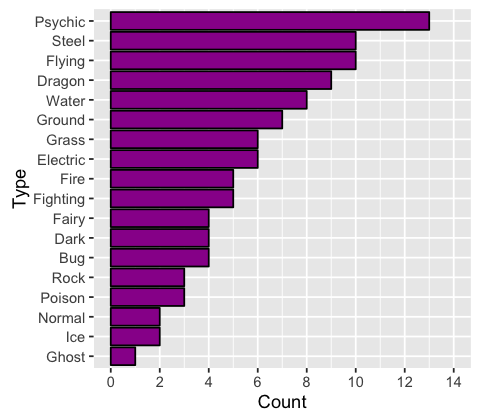

In [10]:
all_types <- c(ou_pkmn_data$Type.1, ou_pkmn_data$Type.2[ou_pkmn_data$Type.2!=''])
type_df <- data.frame(sort(table(all_types), decreasing=F))
colnames(type_df) <- c('Type', 'Count')

ggplot(data=type_df, aes(x=Type, y=Count)) +
    geom_bar(stat="identity", fill="#990099", colour="black") +
    scale_y_continuous(limits=c(0, 14), breaks=seq(0,14,2)) +
    coord_flip()

Looks like Psychic is the most common while Ghost is least common.

<h2>3.2 Single vs. Dual Type</h2>

How many Pokemon are dual type vs single type?

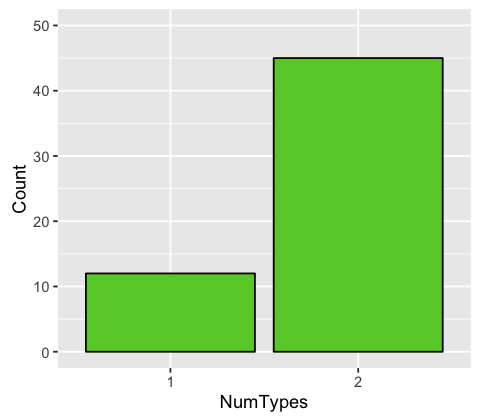

In [11]:
num_types <- ifelse(ou_pkmn_data$Type.2=='', 1, 2)

num_types_df <- data.frame(table(num_types))
colnames(num_types_df) <- c('NumTypes', 'Count')

ggplot(data=num_types_df, aes(x=NumTypes, y=Count)) +
    geom_bar(stat="identity", colour="black", fill="#66cc33") +
    scale_y_continuous(limits=c(0, 50), breaks=seq(0, 50, 10))

Looks like most Pokemon in OU have two types.

<h1>4 Stats</h1>

<h2>4.1 Stat Distribution</h2>

A Pokemon's stats are a good indicator of how good they'll be at a particular competitive role. Let's look at a distribution of the stats.

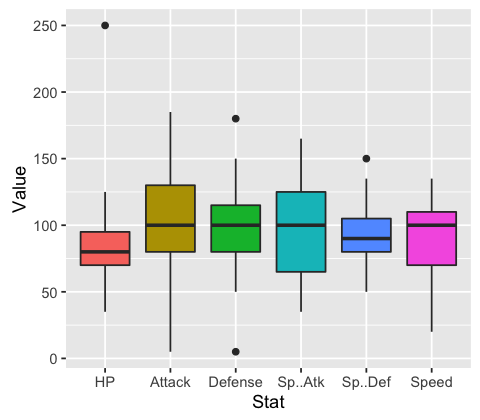

In [12]:
library(reshape2)

stat_data <- melt(ou_pkmn_data, 
                  measure.vars=c('HP', 'Attack', 'Defense', 'Sp..Atk', 'Sp..Def', 'Speed'), 
                  id=c('Legendary', 'Mega'))
ggplot(data=stat_data) +
    geom_boxplot(aes(variable, value, fill=variable)) +
    xlab('Stat') +
    ylab('Value') +
    guides(fill=F)

Looks like for the most part, median stats are about the same sans HP.

In [13]:
library(matrixStats)

stat_names = c('HP', 'Atk', 'Sp. Atk', 'Def', 'Sp. Def', 'Speed')
stat_medians = colMedians(data.matrix(ou_pkmn_data[,5:10]))
stat_df <- data.frame(stat_medians)
rownames(stat_df) <- stat_names
colnames(stat_df) <- 'Median'
stat_df

matrixStats v0.51.0 (2016-10-08) successfully loaded. See ?matrixStats for help.


,Median
HP,80
Atk,100
Sp. Atk,100
Def,100
Sp. Def,90
Speed,100


<h2>4.2 Base Stat Total</h2>

Neat. What are the BSTs like?

[1] 580


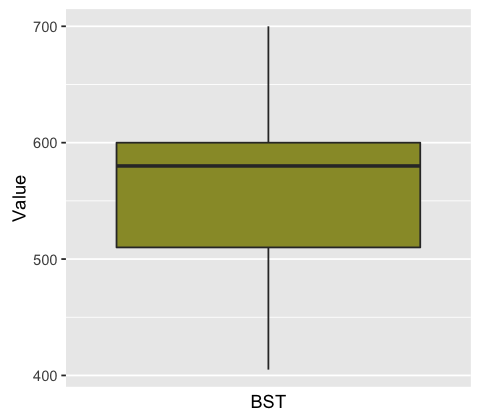

In [14]:
options(repr.plot.width=4, repr.plot.height=3.5)

ggplot(data=ou_pkmn_data, aes(x=factor(0), y=ou_pkmn_data$Total)) +
    geom_boxplot(fill="#999933") +
    scale_x_discrete(breaks=NULL) +
    xlab("BST") +
    ylab('Value') +
    guides(fill=F)

print(median(ou_pkmn_data$Total))

A median BST of 580 makes sense with median stats of 90-100. 

<h2>4.3 Max Stats</h2>

Let's look at the top Pokemon in each stat.

In [15]:
# there's almost certainly a better way to do this
max_stat_pkmn <- rbind(ou_pkmn_data$Name[which.max(ou_pkmn_data$HP)],
                       ou_pkmn_data$Name[which.max(ou_pkmn_data$Attack)],
                       ou_pkmn_data$Name[which.max(ou_pkmn_data$Sp..Atk)],
                       ou_pkmn_data$Name[which.max(ou_pkmn_data$Defense)],
                       ou_pkmn_data$Name[which.max(ou_pkmn_data$Sp..Def)],
                       ou_pkmn_data$Name[which.max(ou_pkmn_data$Speed)])

max_stat <- rbind(max(ou_pkmn_data[which.max(ou_pkmn_data$HP),5:10]),
                  max(ou_pkmn_data[which.max(ou_pkmn_data$Attack),5:10]),
                  max(ou_pkmn_data[which.max(ou_pkmn_data$Sp..Atk),5:10]),
                  max(ou_pkmn_data[which.max(ou_pkmn_data$Defense),5:10]),
                  max(ou_pkmn_data[which.max(ou_pkmn_data$Sp..Def),5:10]),
                  max(ou_pkmn_data[which.max(ou_pkmn_data$Speed),5:10]))

max_pkmn <- data.frame(cbind(stat_names, max_stat_pkmn, max_stat))
colnames(max_pkmn) <- c('Stat', 'Pokemon', 'Value')
max_pkmn              

,Stat,Pokemon,Value
1,HP,Chansey,250
2,Atk,Mega Heracross,185
3,Sp. Atk,Mega Gardevoir,165
4,Def,Mega Slowbro,180
5,Sp. Def,Mega Latias,150
6,Speed,Mega Manectric,135


<h2>4.4 Legendaries & Mega Evolutions</h2>

Now let's compare Legendaries with non-Legendaries.

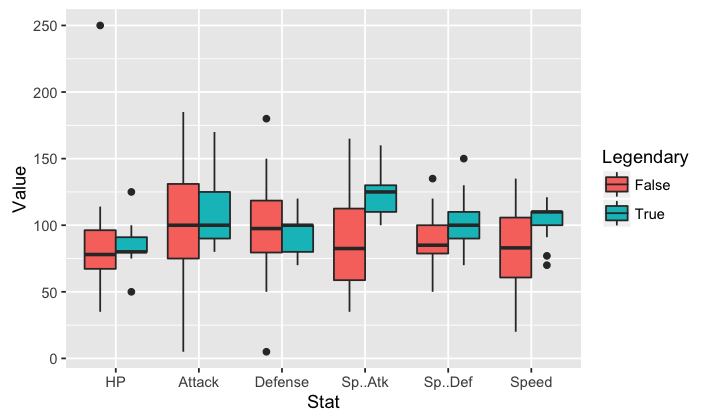

In [16]:
options(repr.plot.width=6, repr.plot.height=3.5)

ggplot(data=stat_data) +
    geom_boxplot(aes(variable, value, fill=factor(Legendary))) +
    xlab('Stat') +
    ylab('Value') +
    scale_fill_discrete(labels=c('False', 'True'), name='Legendary')

Looks like HP, Attack, and Defense are about the same between the two groups, while the rest of the stats are Legendary dominated.

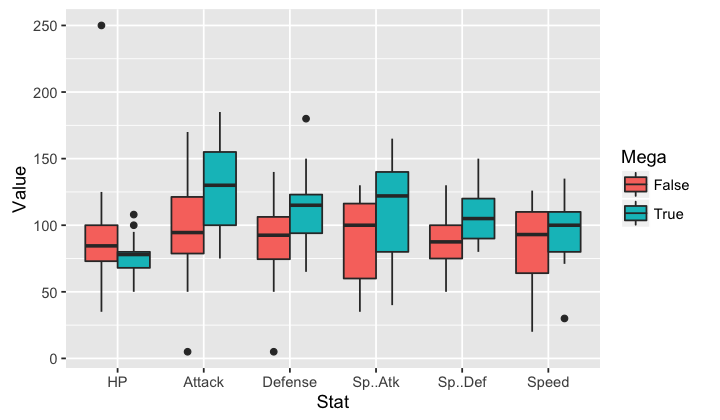

In [17]:
ggplot(data=stat_data) +
    geom_boxplot(aes(variable, value, fill=factor(Mega))) +
    xlab('Stat') +
    ylab('Value') +
    scale_fill_discrete(labels=c('False', 'True'), name='Mega')

For Mega Evolutions, every stat is higher except HP. This makes sense since HP doesn't change with Mega Evolution. The reason that it is lower is likely because there are some Pokemon who are only in OU in their Mega form.

Now for BST.

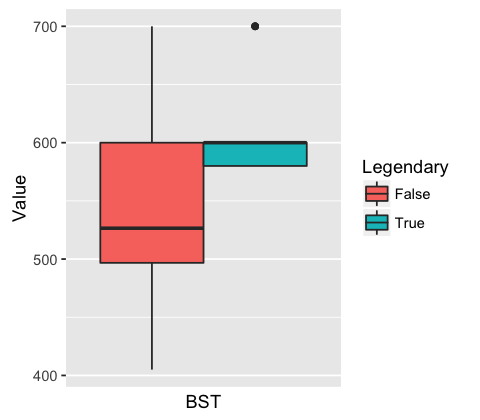

In [18]:
options(repr.plot.width=4, repr.plot.height=3.5)

ggplot(data=ou_pkmn_data, aes(x=factor(0), y=ou_pkmn_data$Total)) +
    geom_boxplot(aes(fill=Legendary)) +
    scale_x_discrete(breaks=NULL) +
    xlab("BST") +
    ylab('Value') +
    scale_fill_discrete(labels=c('False', 'True'), name='Legendary')

Legendary Pokemon seem to have a very small range of BSTs around 600.

Now for Megas...

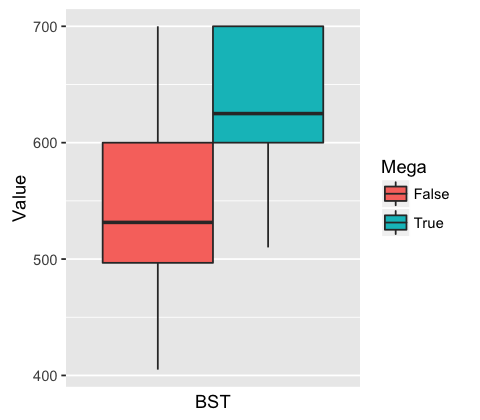

In [19]:
ggplot(data=ou_pkmn_data, aes(x=factor(0), y=ou_pkmn_data$Total)) +
    geom_boxplot(aes(fill=Mega)) +
    scale_x_discrete(breaks=NULL) +
    xlab("BST") +
    ylab('Value') +
    scale_fill_discrete(labels=c('False', 'True'), name='Mega')

That's a pretty sizable increase in BST. This makes sense seeing as how BST increases by 100 during Mega Evolution.

<h1>5 Generation</h1>

Let's see how many Pokemon from each Generation are represented.

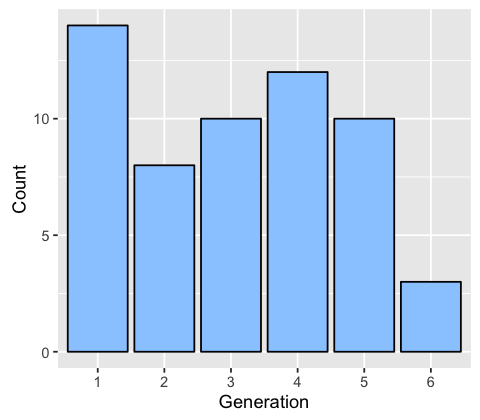

In [20]:
gen_df <- data.frame(table(ou_pkmn_data$Generation))
colnames(gen_df) <- c('Generation', 'Count')
ggplot(data=gen_df, aes(x=Generation, y=Count)) +
    geom_bar(stat="identity", fill='#99ccff', colour="black")

A lot of Gen I Pokemon. Though I wonder, how would the plot look if we factored in Mega Evolutions and Legendaries?

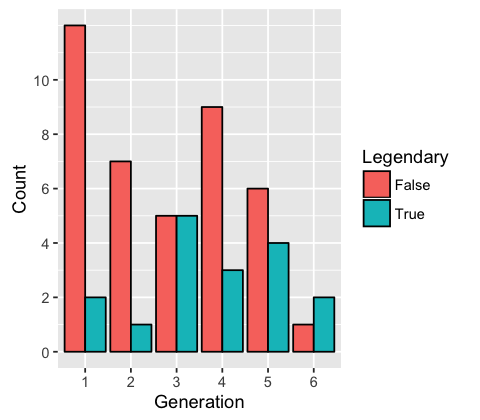

In [21]:
leg_df <- data.frame(table(ou_pkmn_data$Generation, ou_pkmn_data$Legendary))
colnames(leg_df) <- c('Generation', 'Legendary', 'Count')
ggplot(data=leg_df, aes(x=Generation, y=Count, fill=Legendary)) +
    geom_bar(stat="identity", position="dodge", colour="black") +
    scale_fill_discrete(label=c('False', 'True')) +
    scale_y_continuous(breaks=seq(0,10,2))

Looks like most Legendary Pokemon come from Hoenn onwards.

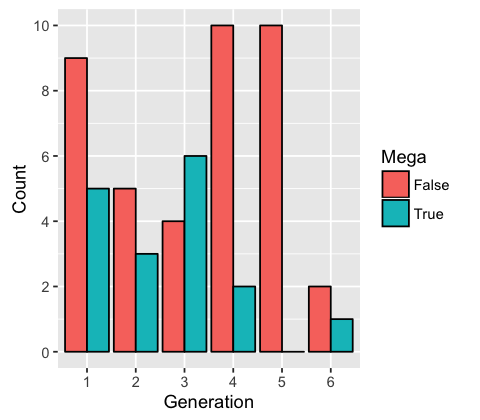

In [22]:
mega_df <- data.frame(table(ou_pkmn_data$Generation, ou_pkmn_data$Mega))
colnames(mega_df) <- c('Generation', 'Mega', 'Count')
ggplot(data=mega_df, aes(x=Generation, y=Count, fill=Mega)) +
    geom_bar(stat="identity", position="dodge", colour="black") +
    scale_fill_discrete(label=c('False', 'True')) +
    scale_y_continuous(breaks=seq(0,10,2))

Looks like there are more non-Mega Pokemon from every generation except III. Also interesting to note is that there are no Mega Evolutions from Gen V. likely because the only Mega Evolution from that generation is Mega Audino.